## Kato et al. (2023) の図9, 10を描くためのスクリプト（2つのピークを描く: AW-H用）
* cressの1分間雨量を積算し1時間積算雨量を計算(図9)
* blendの1時間積算雨量の差分を計算(図9)
* 1分間雨量を回転させ、時間変化を描画(図10)

In [231]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.io.shapereader as shapereader
import xarray as XR
import metpy
from metpy.units import units
import metpy.calc as mpcalc
#from mpl_toolkits.basemap import cm
import sys # to get argv
import os
import warnings
warnings.filterwarnings('ignore')

In [326]:
#---読み込むデータの設定-------
#argvs = sys.argv
#nc =  argvs[1] 

exp = 'AW-H'      # No-WVL-DA
#exp = 'AVW-H'     # Ko & Na
#exp = 'AVW-H-LKO'  # Na
#exp = 'AVW-H-LNA' # Ko

# cress
nc_c = f'../data/cress/{exp}/CReSS*.nc' # 指定実験
#nc_c = f'/Users/katon/Documents/NIED/SIP2/210924_SIP10月の評価会に向けての解析/data/cress/{exp}/CReSS*.nc' # 指定実験

# blend
nc_b = f'../data/cress/{exp}/blendRRP.nc'     # 指定実験
nc_b2 = '../data/cress/AW-H/blendRRP.nc'      # No-WVL-DA (基準実験： 指定実験との差を計算するために利用)

# 抽出領域の設定
#xmin, xmax, ymin, ymax = 130.1, 131.4, 31.7, 32.5 # 可視化領域の設定
xmin, xmax, ymin, ymax = 129.8, 131.4, 31.7, 32.5 # 可視化領域の設定（南西側）
xmin, xmax, ymin, ymax = 130.3, 131.2, 31.94, 32.3 # 可視化領域の設定（北東側）

# 積算する際の時刻の設定
t0 = "2021-07-09T16:00" # 16:00 UTC = 01:00 JST 計算開始
t1 = "2021-07-09T17:00" # 17:00 UTC = 02:00 JST 計算開始
t12 = "2021-07-09T17:01" # 17:01 UTC = 02:01 JST 計算開始
t2 = "2021-07-09T18:00" # 18:00 UTC = 03:00 JST 計算開始
#t2 = "2021-07-09T17:59" # 17:59 UTC = 02:59 JST 計算開始 => P1h計算のbagと整合的になるように、59分まで積算する?

# カラーマップの設定
vmin = 0; vmax = 70; cmap = "rainbow"; levels = np.arange(10, 1000, 10) # for P1h

In [327]:
#--- データの読み込み------------------
# for forecast
da_c  = XR.open_mfdataset(nc_c).sel(LON=slice(xmin,xmax)).sel(LAT=slice(ymin,ymax))
da_b  =   XR.open_dataset(nc_b).sel(LON=slice(xmin,xmax)).sel(LAT=slice(ymin,ymax)) 
da_b2 =  XR.open_dataset(nc_b2).sel(LON=slice(xmin,xmax)).sel(LAT=slice(ymin,ymax)) 

p     = da_c["PA1MIN"]     # cressデータの1分間積算雨量
p1h2b  = da_b["MODEL-ORG-R60M"] # 前1時間積算雨量(FT=2) blendデータ（確認用）
p1h2b2 = da_b2["MODEL-ORG-R60M"] # 前1時間積算雨量(FT=2) blendデータ（確認用）

rp    = da_b["BLEND-R03HRP"]   # 再現期間(return period) blendデータ

diff = p1h2b - p1h2b2 # * - No-WVL-DA

#--- 積算雨量の計算--------------------------
p1h1 = p.sel(TIME=slice(t0,t1)).sum("TIME")
p1h2 = p.sel(TIME=slice(t12,t2)).sum("TIME")
p2h = p.sel(TIME=slice(t0,t2)).sum("TIME")

<xarray.DataArray 'BLEND-R03HRP' ()>
array(9.484225, dtype=float32)

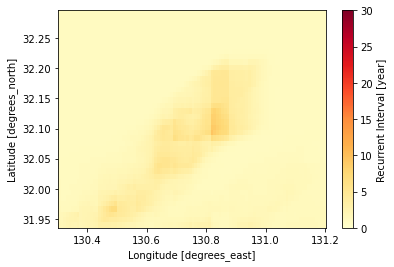

In [328]:
# 再現期間の可視化と最大値
rp.plot(vmin=0, vmax=30, cmap="YlOrRd")
rp.max()

In [329]:
# P1h(FT=0-1h)を可視化
#p1h1.plot(cmap=cmap, vmin=vmin, vmax=vmax)
#p1h1.plot.contour(levels=levels, colors = 'k')

In [330]:
# P1h(FT=1-2h)を可視化
#p1h2.plot(cmap=cmap, vmin=vmin, vmax=vmax)
#p1h2.plot.contour(levels=levels, colors = 'k')

In [331]:
# theta 度反時計回りに回転させた回転させた座標の作成
  # 出力： * (x, y): 補間先の座標
  #      * (lon, lat): 補間先の座標における元の座標で見たときの緯度経度
  #      * (xmax, ymax): 補間先の座標の北東端（右上）の座標
    
theta = 17.0 # 反時計回りに回転する角度(deg)
dx = 0.010; dy = dx # 補間先の座標の解像度(deg)

# narrow
xmin = 130.4; ymin = 31.95 # 補間先の座標の左下の座標(deg)
lx = 0.80 # 補間先の座標のX方向の幅(deg)
ly = 0.10 # 補間先の座標のY方向の幅(deg)

# medium
#xmin = 130.0; ymin = 31.8 # 補間先の座標の左下の座標(deg)
#lx = 1.30 # 補間先の座標のX方向の幅(deg)
#ly = 0.15 # 補間先の座標のY方向の幅(deg)

# wide
#xmin = 130.0; ymin = 31.70 # 補間先の座標の左下の座標(deg)
#lx = 1.30 # 補間先の座標のX方向の幅(deg)
#ly = 0.35 # 補間先の座標のY方向の幅(deg)

def set_new_coordinate(theta, xmin, ymin, dx, dy, lx, ly):
    xmax = xmin + lx
    ymax = ymin + ly
    nx = int( ( (xmax - xmin) / dx ) ) + 1
    ny = int( ( (ymax - ymin) / dy ) ) + 1
    # new coordinate
    x = np.linspace(xmin, xmax, nx)
    y = np.linspace(ymin, ymax, ny)

    # relation between new and original coordinates
      # 以下のページの2番目の例を参考にした。
      # https://docs.xarray.dev/en/stable/user-guide/interpolation.html#example
    lon = XR.DataArray(
            xmin 
            + (x[:, np.newaxis] - xmin) * np.cos(theta * np.pi / 180)
            - (y[np.newaxis, :] - ymin) * np.sin(theta * np.pi / 180),
             dims=["x", "y"],
             coords={"x": x, "y": y})

    lat = XR.DataArray(
            ymin 
            + (x[:, np.newaxis] - xmin) * np.sin(theta * np.pi / 180)
            + (y[np.newaxis, :] - ymin) * np.cos(theta * np.pi / 180),
             dims=["x", "y"],
             coords={"x": x, "y": y})
    return x, y, lon, lat, xmax, ymax

x, y, lon, lat, xmax2, ymax2 = set_new_coordinate(theta, xmin, ymin, dx, dy, lx, ly)


In [332]:
# 回転させた座標への補間
p1h2i  = p1h2.interp(LON=lon, LAT=lat).transpose("y", "x") # 線形(bilinear)内挿
p1h2in = p1h2.interp(LON=lon, LAT=lat, method="nearest").transpose("y", "x") # nearest内挿

# nearneigbor補間で平滑化されない値に対して、最大値と平均値を計算する
maxx = p1h2in.max().compute().values 
mean = p1h2in.mean().compute().values
print("max=", maxx)
print("mean=", mean)

max= 64.35
mean= 11.168889


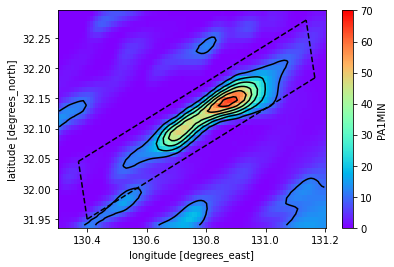

In [333]:
# 補間前の座標で補間後の座標の位置を点線で描く
p1h2.plot(cmap=cmap, vmin=vmin, vmax=vmax)
p1h2.plot.contour(levels=levels, colors = 'k')

def draw_box(lon, lat):
    ixmax = lon[:,0].size - 1
    iymax = lon[0,:].size - 1
    plt.plot(*XR.broadcast(lon.isel(x=0), lat.isel(x=0)), "--k")
    plt.plot(*XR.broadcast(lon.isel(x=ixmax), lat.isel(x=ixmax)), "--k")
    plt.plot(*XR.broadcast(lon.isel(y=0), lat.isel(y=0)), "--k")
    plt.plot(*XR.broadcast(lon.isel(y=iymax), lat.isel(y=iymax)), "--k")    

draw_box(lon, lat)

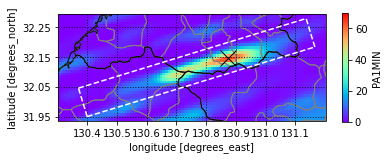

In [334]:
#---プロット領域の作成-----------
proj = ccrs.PlateCarree() # 正距円筒図法
#fig = plt.figure(figsize=(8,3))
fig = plt.figure(figsize=(6,2))

ax = fig.add_subplot(1, 1, 1, projection=proj)

#---シェードを描く-------------------
#vmin = 50; vmax = 75 
cmap = "GnBu"
cmap = "rainbow"

p1h2.plot(transform=proj, cmap=cmap, vmin=vmin, vmax=vmax)
#p1h2.plot.contour(transform=proj,levels=levels, colors = 'k')

def draw_box(lon, lat):
    ixmax = lon[:,0].size - 1
    iymax = lon[0,:].size - 1
    plt.plot(*XR.broadcast(lon.isel(x=0), lat.isel(x=0)), "--w")
    plt.plot(*XR.broadcast(lon.isel(x=ixmax), lat.isel(x=ixmax)), "--w")
    plt.plot(*XR.broadcast(lon.isel(y=0), lat.isel(y=0)), "--w")
    plt.plot(*XR.broadcast(lon.isel(y=iymax), lat.isel(y=iymax)), "--w")    

draw_box(lon, lat)

def calc_maxloc(var):
    lon = var.coords["LON"]
    lat = var.coords["LAT"]
    maxloc = var.argmax(dim=["LON","LAT"])
    lon_max = lon[maxloc["LON"].data]
    lat_max = lat[maxloc["LAT"].data]
    return lon_max, lat_max

lon_max, lat_max = calc_maxloc(p1h2)
#plt.plot(lon_max, lat_max, marker='x', color='red', markersize=10, fillstyle='none', mew=1)
plt.plot(lon_max, lat_max, marker='x', color='black', markersize=16, fillstyle='none', mew=1)


#---緯度線、経度線を描く----------
dlon, dlat = 0.1, 0.1
xticks = np.arange(xmin, xmax, dlon)
yticks = np.arange(ymin, ymax, dlat)

#ax.coastlines(resolution='10m') #日本以外の地図が必要・海岸線を太い線にする場合はコメントを外す
ax.set_xticks(xticks,crs=proj)
ax.set_yticks(yticks,crs=proj)

#dl = 0.001
#ax.set_extent([xmin-dl, xmax+dl, ymin-dl, ymax+dl], crs=proj)  # 領域の限定

gl = ax.gridlines(crs=proj, draw_labels=False,
                  linewidth=1, linestyle=':', color='k', alpha=0.8)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(xticks)  # 経度線
gl.ylocator = mticker.FixedLocator(yticks)  # 緯度線

#---陸・海・川・湖を塗り分けて描く----------------
#!ax.add_feature(cfeature.LAND)  # 可視化する領域を狭く5度×5度くらいにすると、
#!ax.add_feature(cfeature.OCEAN) # LANDやOCEANを描くと合わせて20秒近くかかってしまう...
ax.add_feature(cfeature.COASTLINE, linewidth=1)
#ax.add_feature(cfeature.LAKES)
#!#ax.add_feature(cfeature.LAKES, alpha=0.5)
#ax.add_feature(cfeature.RIVERS)

#---県境・市町村境界を描く-----
#  * 以下のWebページを参考にDLしたシェープファイル利用:
#    * Pythonで世界地図-26(各国の県境・市町村境を表示): https://qiita.com/ty21ky/items/193e316370a8c7122b3c 
#fname = 'gadm36_JPN_shp/gadm36_JPN_0.shp' #国境線のみ
fname1 = 'gadm36_JPN_shp/gadm36_JPN_1.shp' #県境
fname2 = 'gadm36_JPN_shp/gadm36_JPN_2.shp' #市町村境

adm1_shapes = list(shapereader.Reader(fname1).geometries())
adm2_shapes = list(shapereader.Reader(fname2).geometries())
#ax.add_geometries(adm2_shapes, proj, edgecolor='gray', facecolor='cyan',  alpha=0.5) #市町村境
#ax.add_geometries(adm2_shapes, proj, edgecolor='gray',  alpha=0.5) #市町村境
#ax.add_geometries(adm2_shapes, proj, edgecolor='gray', facecolor='none',alpha=0.8) #市町村境
#ax.add_geometries(adm1_shapes, proj, edgecolor='black', facecolor='none',alpha=1) #県境
ax.add_geometries(adm2_shapes, proj, edgecolor='gray', facecolor='none',alpha=1) #市町村境
ax.add_geometries(adm1_shapes, proj, edgecolor='black', facecolor='none',alpha=0.8) #県境

#------------------------------------
# ファイルへの書き出し
##from pathlib import Path
##exe = Path().resolve().split(".")[0] #.replace("draw", "")
##exe = os.path.basename(__file__).split(".")[0] #.replace("draw", "")
fig_name = "fig_P1h.png"
##fig_name = "fig_" + exe + ".png"

#print(fig_name)
#plt.savefig(fig_name, dpi=300, bbox_inches='tight')
#plt.show()

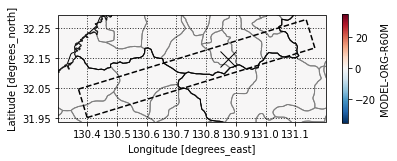

In [335]:
#---プロット領域の作成-----------
proj = ccrs.PlateCarree() # 正距円筒図法
#fig = plt.figure(figsize=(8,3))
fig = plt.figure(figsize=(6,2))

ax = fig.add_subplot(1, 1, 1, projection=proj)

#---シェードを描く-------------------
#vmin = 50; vmax = 75 
cmap = "GnBu"
cmap = "rainbow"

#p1h2.plot(transform=proj, cmap=cmap, vmin=vmin, vmax=vmax)
#p1h2.plot.contour(transform=proj,levels=levels, colors = 'k')
vmind = -35; vmaxd = -vmind
#vmind = -5; vmaxd = -vmind

cmapd = "RdBu_r"
diff.plot(transform=proj, cmap=cmapd, vmin=vmind, vmax=vmaxd)
#p1h2b.plot.contour(transform=proj,levels=[5, 10, 30], colors = 'k')


def draw_box(lon, lat):
    ixmax = lon[:,0].size - 1
    iymax = lon[0,:].size - 1
    plt.plot(*XR.broadcast(lon.isel(x=0), lat.isel(x=0)), "--k")
    plt.plot(*XR.broadcast(lon.isel(x=ixmax), lat.isel(x=ixmax)), "--k")
    plt.plot(*XR.broadcast(lon.isel(y=0), lat.isel(y=0)), "--k")
    plt.plot(*XR.broadcast(lon.isel(y=iymax), lat.isel(y=iymax)), "--k")    

draw_box(lon, lat)

def calc_maxloc(var):
    lon = var.coords["LON"]
    lat = var.coords["LAT"]
    maxloc = var.argmax(dim=["LON","LAT"])
    lon_max = lon[maxloc["LON"].data]
    lat_max = lat[maxloc["LAT"].data]
    return lon_max, lat_max

lon_max, lat_max = calc_maxloc(p1h2)
#plt.plot(lon_max, lat_max, marker='x', color='red', markersize=10, fillstyle='none', mew=1)
plt.plot(lon_max, lat_max, marker='x', color='black', markersize=16, fillstyle='none', mew=1)


#---緯度線、経度線を描く----------
dlon, dlat = 0.1, 0.1
xticks = np.arange(xmin, xmax, dlon)
yticks = np.arange(ymin, ymax, dlat)

#ax.coastlines(resolution='10m') #日本以外の地図が必要・海岸線を太い線にする場合はコメントを外す
ax.set_xticks(xticks,crs=proj)
ax.set_yticks(yticks,crs=proj)

#dl = 0.001
#ax.set_extent([xmin-dl, xmax+dl, ymin-dl, ymax+dl], crs=proj)  # 領域の限定

gl = ax.gridlines(crs=proj, draw_labels=False,
                  linewidth=1, linestyle=':', color='k', alpha=0.8)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(xticks)  # 経度線
gl.ylocator = mticker.FixedLocator(yticks)  # 緯度線

#---陸・海・川・湖を塗り分けて描く----------------
#!ax.add_feature(cfeature.LAND)  # 可視化する領域を狭く5度×5度くらいにすると、
#!ax.add_feature(cfeature.OCEAN) # LANDやOCEANを描くと合わせて20秒近くかかってしまう...
ax.add_feature(cfeature.COASTLINE, linewidth=1)
#ax.add_feature(cfeature.LAKES)
#!#ax.add_feature(cfeature.LAKES, alpha=0.5)
#ax.add_feature(cfeature.RIVERS)

#---県境・市町村境界を描く-----
#  * 以下のWebページを参考にDLしたシェープファイル利用:
#    * Pythonで世界地図-26(各国の県境・市町村境を表示): https://qiita.com/ty21ky/items/193e316370a8c7122b3c 
#fname = 'gadm36_JPN_shp/gadm36_JPN_0.shp' #国境線のみ
fname1 = 'gadm36_JPN_shp/gadm36_JPN_1.shp' #県境
fname2 = 'gadm36_JPN_shp/gadm36_JPN_2.shp' #市町村境

adm1_shapes = list(shapereader.Reader(fname1).geometries())
adm2_shapes = list(shapereader.Reader(fname2).geometries())
ax.add_geometries(adm2_shapes, proj, edgecolor='gray', facecolor='none',alpha=1) #市町村境
ax.add_geometries(adm1_shapes, proj, edgecolor='black', facecolor='none',alpha=0.8) #県境

#------------------------------------
# ファイルへの書き出し
##from pathlib import Path
##exe = Path().resolve().split(".")[0] #.replace("draw", "")
##exe = os.path.basename(__file__).split(".")[0] #.replace("draw", "")
fig_name = "fig_P1h.png"
##fig_name = "fig_" + exe + ".png"

#print(fig_name)
#plt.savefig(fig_name, dpi=300, bbox_inches='tight')
#plt.show()

In [336]:
#diff.plot(cmap=cmapd, vmin=vmind, vmax=vmaxd)

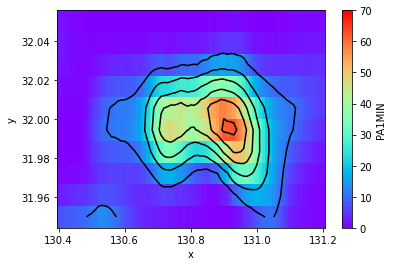

In [337]:
# 回転させた座標で可視化（簡易版）
p1h2i.plot(cmap=cmap, vmin=vmin, vmax=vmax)
p1h2i.plot.contour(levels=levels, colors = 'k')

In [338]:
t1 = "2021-07-09T16:05" # 16:01 UTC = 01:01 JST 計算開始
t2 = "2021-07-09T18:00" # 18:00 UTC = 03:00 JST 計算開始
rr = p.interp(LON=lon, LAT=lat).sel(TIME=slice(t1, t2, 5)) * 60 # 1分間雨量を補間し、時間切り出しし、mm/hに変換

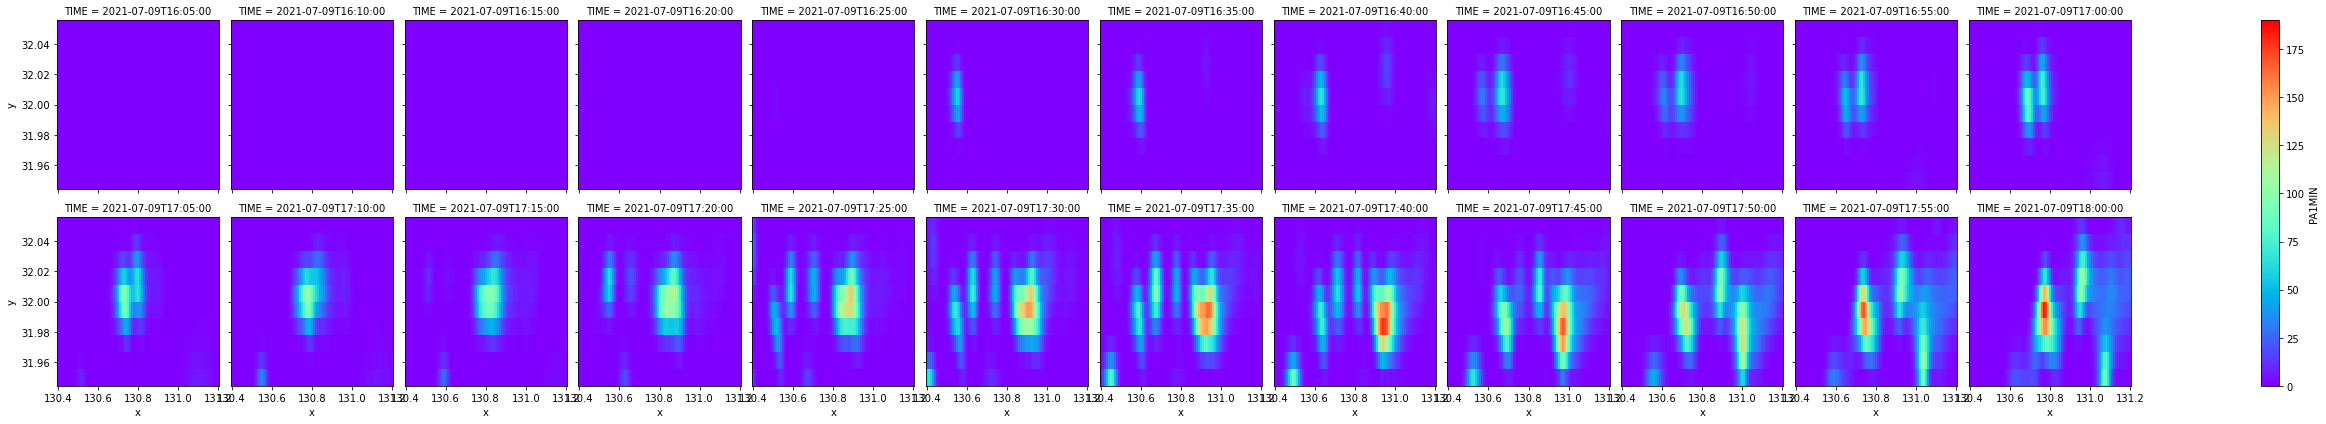

In [339]:
# RRの簡易的な可視化
vmin2 = 0; vmax2 = 190; cmap2 = "rainbow" 
rr.plot(cmap=cmap2, vmin=vmin2, vmax=vmax2, x="x", y="y", col="TIME", col_wrap=12)

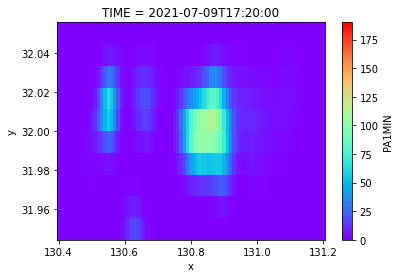

In [340]:
rr.isel(TIME=15).plot(x="x", y="y", vmin=vmin2, vmax=vmax2, cmap=cmap)#,levels=levels, cbar_kwargs={'label':'RR (mm s$^{-1}$)'})

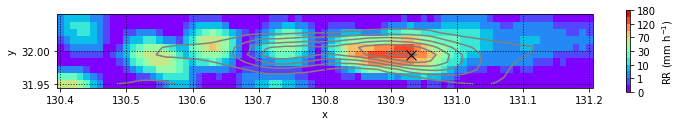

In [341]:
#---プロット領域の作成-----------
proj = ccrs.PlateCarree() # 正距円筒図法
fig = plt.figure(figsize=(12,1.5))
ax = fig.add_subplot(1, 1, 1, projection=proj)

#---シェードを描く-------------------
#vmin = 50; vmax = 75 
cmap = "GnBu"
cmap = "rainbow"
#levels_rr = [1, 25, 50, 100, 150, 200]
levels_rr = [0, 0.1, 1, 5, 10, 20, 30, 50, 70, 90, 120, 150, 180]
#levels_rr = [0, 1, 5, 10, 20, 30, 50, 70, 90, 120, 150, 180, 210]

var1 = rr.isel(TIME=17)
var1.plot(ax=ax,transform=proj, x="x", y="y", vmin=vmin2, vmax=vmax2, cmap=cmap,levels=levels_rr, cbar_kwargs={'label':'RR (mm h$^{-1}$)'})

var = p1h2i
var.plot.contour(levels=levels, colors = 'gray')

def draw_maxloc(var):
    lon = var.coords["x"]
    lat = var.coords["y"]
    maxloc = var.argmax(dim=["x","y"])
    lon_max = lon[maxloc["x"].data]
    lat_max = lat[maxloc["y"].data]
    plt.plot(lon_max, lat_max, marker='x', color='black', markersize=10, fillstyle='none', mew=1)

draw_maxloc(var)

#---緯度線、経度線を描く----------
dlon, dlat = 0.1, 0.05
xticks = np.arange(xmin, xmax2, dlon)
yticks = np.arange(ymin, ymax2, dlat)

#ax.coastlines(resolution='10m') #日本以外の地図が必要・海岸線を太い線にする場合はコメントを外す
ax.set_xticks(xticks,crs=proj)
ax.set_yticks(yticks,crs=proj)

#dl = 0.001
#ax.set_extent([xmin-dl, xmax+dl, ymin-dl, ymax+dl], crs=proj)  # 領域の限定

gl = ax.gridlines(crs=proj, draw_labels=False,
                  linewidth=1, linestyle=':', color='k', alpha=0.8)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(xticks)  # 経度線
gl.ylocator = mticker.FixedLocator(yticks)  # 緯度線

#------------------------------------
# ファイルへの書き出し
##from pathlib import Path
##exe = Path().resolve().split(".")[0] #.replace("draw", "")
##exe = os.path.basename(__file__).split(".")[0] #.replace("draw", "")
fig_name = "fig_brendrrp_P1h.png"
##fig_name = "fig_" + exe + ".png"

#print(fig_name)
#plt.savefig(fig_name, dpi=300, bbox_inches='tight')
#plt.show()

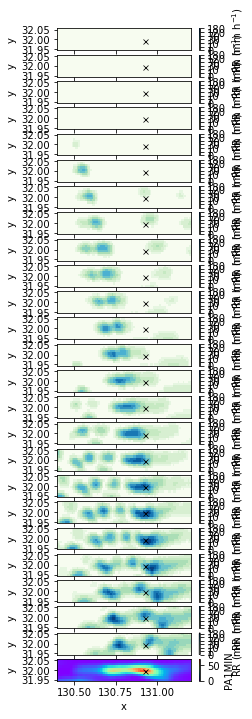

In [342]:
#---プロット領域の作成-----------
proj = ccrs.PlateCarree() # 正距円筒図法

#fig = plt.figure(figsize=(12,1.5))
#ax = fig.add_subplot(1, 1, 1, projection=proj)

nt = 24 + 1
fig, ax = plt.subplots(nt,1, figsize=(3, 12), sharex=True)#, projection=proj)#, sharex=True)

#fig = plt.figure(figsize=(6,12))
#ax  = fig.add_subplot(nt, 1, nt, projection=proj)
#ax  = fig.add_subplot(nt, 2, nt)


#---シェードを描く-------------------
#vmin = 50; vmax = 75 
cmap = "GnBu"
#cmap = "rainbow"
#cmap = cm.GMT_drywet
#levels_rr = [0, 0.1, 1, 5, 10, 20, 30, 50, 70, 90, 120, 150]
levels_rr = [0, 0.1, 1, 5, 10, 20, 30, 50, 70, 90, 120, 150, 180]
#levels_rr = [0, 1, 5, 10, 20, 30, 50, 70, 90, 120, 150, 180, 210]
#levels_1h = [40, 50, 60]
levels_1h = [45, 50, 55]

var =p1h2i

def calc_maxloc(var):
    lon = var.coords["x"]
    lat = var.coords["y"]
    maxloc = var.argmax(dim=["x","y"])
    lon_max = lon[maxloc["x"].data]
    lat_max = lat[maxloc["y"].data]
    return lon_max, lat_max

lon_max, lat_max = calc_maxloc(var)
  
# RR 図の可視化
for i in range(nt-1):

    rr.isel(TIME=i).plot(ax=ax[i], x="x", y="y", vmin=vmin2, vmax=vmax2, cmap=cmap,levels=levels_rr, cbar_kwargs={'label':'RR (mm h$^{-1}$)'})
#    rr.isel(TIME=i).plot(ax=ax[i],transform=proj, x="x", y="y", vmin=vmin2, vmax=vmax2, cmap=cmap,levels=levels_rr, cbar_kwargs={'label':'RR (mm h$^{-1}$)'})
#    rr.isel(TIME=i).plot(ax=ax[i], x="x", y="y", vmin=vmin2, vmax=vmax2, cmap=cmap,levels=levels_rr, cbar_kwargs={'label':''})
    ax[i].set_title('')
#    var.plot.contour(ax=ax[i],levels=[45], colors = 'gray') # コンター(P1h)
    ax[i].plot(lon_max, lat_max, marker='x', color='black', markersize=5, fillstyle='none', mew=0.75) # P1hの最大値の場所をxで描く

# P1h図の可視化    
cmap3 = "GnBu"
cmap3 = "rainbow"
p1h2i.plot(ax=ax[nt-1], cmap=cmap3, vmin=vmin, vmax=vmax)
ax[nt-1].plot(lon_max, lat_max, marker='x', color='black', markersize=5, fillstyle='none', mew=0.75)
#p1h2i.plot.contour(levels=levels, colors = 'k')    
    
#------------------------------------
# ファイルへの書き出し
##from pathlib import Path
##exe = Path().resolve().split(".")[0] #.replace("draw", "")
##exe = os.path.basename(__file__).split(".")[0] #.replace("draw", "")
fig_name = "fig_bb.png"
##fig_name = "fig_" + exe + ".png"

#print(fig_name)
#plt.savefig(fig_name, dpi=300, bbox_inches='tight')
#plt.show()

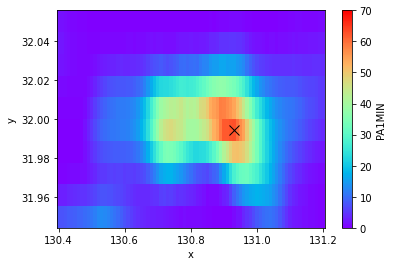

In [343]:
# カラーバーを取得するための図 (P1h)
p1h2i.plot(cmap=cmap3, vmin=vmin, vmax=vmax)
plt.plot(lon_max, lat_max, marker='x', color='black', markersize=10, fillstyle='none', mew=1)

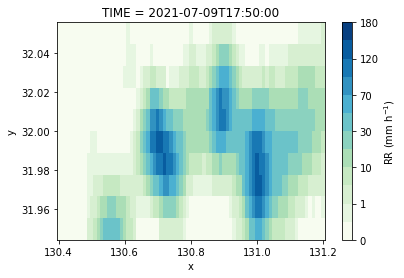

In [344]:
# カラーバーを取得するための図 (RR)
#fig = plt.figure(figsize=(12,12))
rr.isel(TIME=21).plot(x="x", y="y", vmin=vmin2, vmax=vmax2, cmap=cmap,levels=levels_rr, cbar_kwargs={'label':'RR (mm h$^{-1}$)'})